# Estimação do Rt nos estados e municípios
---

- Adaptação das implementações de [Loft-BR](https://github.com/loft-br/realtime_r0_brazil/blob/master/realtime_r0_bettencourt_ribeiro.ipynb) & [COVID Act Now](https://github.com/covid-projections/covid-data-model/blob/089e4e81db32befd6e86e4e105454629fd834ad2/pyseir/inference/infer_rt.py) com base no modelo de [Kevin Systrom](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/) e paper de [Bettencourt & Ribeiro's](https://doi.org/10.1371/journal.pone.0002185)

  
## Cálculo do Rt

Estimação do número de reprodução instantâneo ($Rt$) pelo número de novos casos por dia:


- Modelo bayeasiano no qual o número de novos casos segue uma distribuição de Poisson, e a relação entre os novos casos e $Rt$ é dada pela equação encontrada em Bettencourt & Ribeiro:

$$k \sim Pois(\lambda), \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

- A cada nova observação, atualizamos nossa crença em relação ao valor de $Rt$ pela regra de Bayes:

$$P(k_t) = \sum_{R_t} P(k_t | R_t) P(R_t) \rightarrow P(R_t | k_t) = \frac{P(k_t | R_t) P(R_t)}{P(k_t)}$$ 


### Considerações

- A relação dada por $\lambda = k_{t-1}e^{\gamma(R_t-1)}$ é obtida a partir de $R_0 = \frac{\beta}{\gamma}$, tomando $\beta$ e $\gamma$ fixos, o que não contempla a variabilidade de transmissão devido à intervenções sociais. O [*CovidAct Now* sinaliza, por exemplo, o $R_0$ como o número pré-intervenção e o $R_{eff}$ (efetivo) como pós](https://blog.covidactnow.org/inference-projections-for-states/).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cálculo-do-Rt" data-toc-modified-id="Cálculo-do-Rt-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cálculo do Rt</a></span><ul class="toc-item"><li><span><a href="#Considerações" data-toc-modified-id="Considerações-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Considerações</a></span></li></ul></li><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Import-data" data-toc-modified-id="Import-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import data</a></span><ul class="toc-item"><li><span><a href="#Filter-city-and-state-new-cases" data-toc-modified-id="Filter-city-and-state-new-cases-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filter city and state new cases</a></span></li></ul></li><li><span><a href="#Run-model" data-toc-modified-id="Run-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run model</a></span><ul class="toc-item"><li><span><a href="#Import-model" data-toc-modified-id="Import-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Import model</a></span></li><li><span><a href="#Run-state-model" data-toc-modified-id="Run-state-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Run state model</a></span></li><li><span><a href="#Run-cities-model" data-toc-modified-id="Run-cities-model-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Run cities model</a></span></li><li><span><a href="#For-one-state" data-toc-modified-id="For-one-state-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>For one state</a></span></li><li><span><a href="#All-cities" data-toc-modified-id="All-cities-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>All cities</a></span></li></ul></li><li><span><a href="#Plotting-results" data-toc-modified-id="Plotting-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting results</a></span><ul class="toc-item"><li><span><a href="#State" data-toc-modified-id="State-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>State</a></span></li><li><span><a href="#City" data-toc-modified-id="City-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>City</a></span></li></ul></li><li><span><a href="#Compare-w/-cases" data-toc-modified-id="Compare-w/-cases-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Compare w/ cases</a></span></li><li><span><a href="#TODO:-Avg-estimation-w/-new-deaths-(From-ActNow)" data-toc-modified-id="TODO:-Avg-estimation-w/-new-deaths-(From-ActNow)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TODO: Avg estimation w/ new deaths (From ActNow)</a></span></li><li><span><a href="#Draft" data-toc-modified-id="Draft-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Draft</a></span></li></ul></div>

## Import packages

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import warnings
warnings.filterwarnings('ignore')

# # Plotting
# import plotly
# import plotly.graph_objs as go
# plotly.offline.init_notebook_mode(connected=True)

# # Setting cufflinks
# import textwrap
# import cufflinks as cf
# cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)

# # Centering and fixing title
# def iplottitle(title, width=40):
#     return '<br>'.join(textwrap.wrap(title, width))

# # Adding custom colorscales (to add one: themes/custom_colorscales.yaml)
# import yaml
# custom_colorscales = yaml.load(open('themes/custom_colorscales.yaml', 'r'))
# cf.colors._custom_scales['qual'].update(custom_colorscales)
# cf.colors.reset_scales()

# # Setting cuffilinks template (use it with .iplot(theme='custom')
# cf.themes.THEMES['custom'] = yaml.load(open('themes/cufflinks_template.yaml', 'r'))

In [3]:
# import requests
# from matplotlib import pyplot as plt

# importando joblib para rodar em paralelo
from joblib import Parallel, delayed

# número de cores para paralelizar modelo nos estados
N_JOBS = -1

In [4]:
from src.loader.utils import get_config

config = get_config("https://raw.githubusercontent.com/ImpulsoGov/simulacovid/master/src/configs/config.yaml")

## Import data

In [5]:
from src.loader import get_cases

df = get_cases.now('br',
                   config,
                   last=False)

In [6]:
df.head()

,city,city_id,last_updated,epidemiological_week,estimated_population_2019,is_last,is_repeated,confirmed_cases,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,deaths,order_for_place,place_type,state,daily_cases,new_deaths,infectious_period_cases,state_notification_rate,notification_rate,active_cases
0,São Paulo,3550308,2020-02-25,9,12252023.0,False,False,1,0.00816,2020-02-25,0.0,0,1,city,SP,1.0,0,1.0,NaN,NaN,1.0
1,São Paulo,3550308,2020-02-26,9,12252023.0,False,False,1,0.00816,2020-02-26,0.0,0,2,city,SP,0.0,0,1.0,NaN,NaN,1.0
2,São Paulo,3550308,2020-02-27,9,12252023.0,False,False,1,0.00816,2020-02-27,0.0,0,3,city,SP,0.0,0,1.0,NaN,NaN,1.0
3,São Paulo,3550308,2020-02-28,9,12252023.0,False,False,2,0.01632,2020-02-28,0.0,0,4,city,SP,1.0,0,2.0,NaN,NaN,2.0
4,São Paulo,3550308,2020-02-29,9,12252023.0,False,False,2,0.01632,2020-02-29,0.0,0,5,city,SP,0.0,0,2.0,NaN,NaN,2.0


In [7]:
# check for cities without notification rates in last date
df[(df['is_last'] == True) & (df['notification_rate'].isnull())]

,city,city_id,last_updated,epidemiological_week,estimated_population_2019,is_last,is_repeated,confirmed_cases,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,deaths,order_for_place,place_type,state,daily_cases,new_deaths,infectious_period_cases,state_notification_rate,notification_rate,active_cases


### Filter city and state new cases

In [8]:
def get_cases_series(df, place_type):
    
    return df[~df['state_notification_rate'].isnull()][[place_type, 
                                   'last_updated', 
                                   'active_cases']]\
            .groupby([place_type, 
                      'last_updated'])['active_cases']\
            .sum()\
            .round(0)

In [9]:
city_cases = get_cases_series(df, 'city_id')
city_cases

city_id  last_updated
1100015  2020-05-02         1.0
         2020-05-03         1.0
         2020-05-04         2.0
         2020-05-05         2.0
         2020-05-06         2.0
                          ...  
5300108  2020-05-06      1015.0
         2020-05-07      1172.0
         2020-05-08      1273.0
         2020-05-09      1394.0
         2020-05-10      1413.0
Name: active_cases, Length: 61768, dtype: float64

In [10]:
state_cases = get_cases_series(df, 'state')
state_cases

state  last_updated
AC     2020-04-12       72.0
       2020-04-13       92.0
       2020-04-14      104.0
       2020-04-15      105.0
       2020-04-16      129.0
                       ...  
TO     2020-05-06      470.0
       2020-05-07      566.0
       2020-05-08      736.0
       2020-05-09      990.0
       2020-05-10      987.0
Name: active_cases, Length: 981, dtype: float64

## Run model

### Import model

* Add parameters choice w/ [CovidActNow](https://github.com/covid-projections/covid-data-model/blob/089e4e81db32befd6e86e4e105454629fd834ad2/pyseir/inference/infer_rt.py) implementation and [Loft-BR](https://github.com/loft-br/realtime_r0_brazil/blob/master/core.py)

In [332]:
from model import run_full_model, plot_rt, plot_standings

### Run state model

In [391]:
with Parallel(n_jobs=1) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], source='LOFT') 
                       for grp in state_cases.groupby(level='state'))

state_results = pd.concat(results)

In [392]:
# Check all states
state_results.reset_index().state.unique()

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

* Saving results with cases data

In [393]:
cases_cols = [
    'daily_cases',  
    'confirmed_cases',
    'active_cases'
]

df_state_cases = df[~df['state_notification_rate'].isnull()]\
                    .groupby(['state', 'last_updated'])[cases_cols]\
                    .sum()\
                    .round(0)\
                    .join(df.groupby(['state', 'last_updated'])['state_notification_rate'].max())

state_results = state_results.join(df_state_cases).reset_index()
state_results.head()

,state,last_updated,Rt_most_likely,Rt_low_95,Rt_high_95,daily_cases,confirmed_cases,active_cases,state_notification_rate
0,AC,2020-04-12,3.00,0.67,7.84,5.0,77,72.0,0.698571
1,AC,2020-04-13,1.90,0.75,3.15,13.0,90,92.0,0.641429
2,AC,2020-04-14,1.89,0.93,2.83,9.0,99,104.0,0.664286
3,AC,2020-04-15,1.90,1.07,2.67,2.0,101,105.0,0.653571
4,AC,2020-04-16,2.02,1.32,2.70,14.0,115,129.0,0.630714


In [590]:
state_results.to_csv('br_states_estimated_rt.csv')

### Run cities model

*  Cities with more than 14 days

In [492]:
# Cities in state selected
city_sample = city_cases[city_cases.index.isin(df[df['state'] == state]['city_id'].unique(), level=0)]

# more than 14 days
v = city_sample.reset_index()['city_id'].value_counts()
city_sample = city_sample[city_sample.index.isin(v[v > 14].index, level=0)]

city_sample

city_id  last_updated
2800308  2020-04-08      108.0
         2020-04-09      111.0
         2020-04-10      124.0
         2020-04-11      137.0
         2020-04-12      138.0
                         ...  
2807501  2020-05-06        1.0
         2020-05-07        1.0
         2020-05-08        1.0
         2020-05-09        1.0
         2020-05-10        1.0
Name: active_cases, Length: 487, dtype: float64

In [495]:
len(city_sample.reset_index()['city_id'].unique())

19

### For one state

In [502]:
# Each city in chunks
error_cities = dict()
city_results = list()

for city in city_sample.reset_index()['city_id'].unique():
    
    chunk = city_sample[city_sample.index.isin([city], level=0)]
    
    try:
        with Parallel(n_jobs=1) as parallel:
            city_results.append(parallel(delayed(run_full_model)(grp[1], source='LOFT') 
                       for grp in chunk.groupby(level='city_id')))
    except Exception as e: 
        error_cities[city] = e

In [503]:
error_cities

{2804904: IndexError('index 0 is out of bounds for axis 0 with size 0')}

In [563]:
# city_results = [city_results[0] for k in city_results]
# city_results = [i[0] for i in city_results]
# city_results = pd.concat(city_results)

In [547]:
city_results = city_results.reset_index().merge(df[['city_id', 'city']].drop_duplicates())
city_results

,city_id,last_updated,Rt_most_likely,Rt_low_95,Rt_high_95,city
0,2800308,2020-04-08,3.00,0.67,7.84,Aracaju
1,2800308,2020-04-09,1.68,0.66,2.79,Aracaju
2,2800308,2020-04-10,1.52,0.68,2.34,Aracaju
3,2800308,2020-04-11,1.43,0.71,2.12,Aracaju
4,2800308,2020-04-12,1.34,0.69,1.94,Aracaju
...,...,...,...,...,...,...
393,2807501,2020-05-06,1.80,0.59,3.43,Tomar do Geru
394,2807501,2020-05-07,1.71,0.50,3.25,Tomar do Geru
395,2807501,2020-05-08,1.71,0.51,3.24,Tomar do Geru
396,2807501,2020-05-09,1.70,0.51,3.22,Tomar do Geru


### All cities

In [578]:
from tqdm.notebook import tqdm

In [581]:
def run_all_cities(df, min_days=14, state=False):
    
    if state:
        df = df[df.index.isin(df[df['state'] == state]['city_id'].unique(), level=0)]

    # more than 14 days
    v = df.reset_index()['city_id'].value_counts()
    df = df[df.index.isin(v[v > 14].index, level=0)]

    # Each city in chunks
    error_cities = dict()
    city_results = list()
    
    for city in tqdm(df.reset_index()['city_id'].unique()):

        chunk = df[df.index.isin([city], level=0)]

        try:
            with Parallel(n_jobs=-1) as parallel:
                city_results.append(parallel(delayed(run_full_model)(grp[1], source='LOFT') 
                           for grp in chunk.groupby(level='city_id')))
        except Exception as e: 
            print(e)
            error_cities[city] = e
            
    return city_results, error_cities

In [582]:
all_cities_results, all_cities_erros = run_all_cities(city_cases)

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with

In [587]:
all_cities_results = pd.concat([l[0] for l in all_cities_results])
all_cities_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 39532 entries, (1100023, Timestamp('2020-04-10 00:00:00')) to (5300108, Timestamp('2020-05-10 00:00:00'))
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rt_most_likely  39532 non-null  float64
 1   Rt_low_95       39532 non-null  float64
 2   Rt_high_95      39532 non-null  float64
dtypes: float64(3)
memory usage: 1.0 MB


In [594]:
all_cities_results = all_cities_results.reset_index().merge(df[['city_id', 
                                                                'city', 
                                                                'last_updated', 
                                                                'daily_cases', 
                                                                'confirmed_cases', 
                                                                'active_cases', 
                                                                'notification_rate']], on=['city_id', 
                                                                                           'last_updated'])
all_cities_results#to_csv('br_cities_estimate_rt.csv')

,city_id,last_updated,Rt_most_likely,Rt_low_95,Rt_high_95,city,daily_cases,confirmed_cases,active_cases,notification_rate
0,1100023,2020-04-10,3.00,0.67,7.84,Ariquemes,2.0,2,6.0,0.348571
1,1100023,2020-04-11,2.60,0.73,5.29,Ariquemes,0.0,2,5.0,0.365714
2,1100023,2020-04-12,2.54,0.82,4.70,Ariquemes,5.0,7,18.0,0.385714
3,1100023,2020-04-13,2.57,0.92,4.40,Ariquemes,0.0,7,18.0,0.394286
4,1100023,2020-04-14,2.53,1.03,4.14,Ariquemes,0.0,7,16.0,0.427143
...,...,...,...,...,...,...,...,...,...,...
39527,5300108,2020-05-06,1.34,1.21,1.46,Brasília,186.0,1893,1015.0,0.980469
39528,5300108,2020-05-07,1.36,1.22,1.47,Brasília,185.0,2078,1172.0,1.000000
39529,5300108,2020-05-08,1.37,1.24,1.48,Brasília,139.0,2217,1273.0,1.000000
39530,5300108,2020-05-09,1.38,1.24,1.48,Brasília,133.0,2350,1394.0,1.000000


In [595]:
all_cities_results.to_csv('br_cities_estimated_rt.csv')

## Plotting results

In [557]:
from plots import plot_heatmap, plot_rt, plot_rt_bars

### State

In [561]:
plot_rt_bars(state_results[state_results['last_updated'] == '2020-05-10'], 'Taxa de reprodução efetiva nas UFs')

In [483]:
state = 'SE'

In [484]:
plot_rt(state_results[state_results['state'] == state], 
        title='Evolução do número médio de crescimento da doença em {}'.format(state))

### City

In [562]:
plot_rt_bars(city_results[city_results['last_updated'] == '2020-05-10'], 
             'Taxa de reprodução efetiva nas UFs',
             place_type='city')

In [551]:
city = 'Aracaju'

In [553]:
plot_rt(city_results[city_results['city'] == city], 
        title='Evolução do número médio de crescimento da doença em {}'.format(city))

## Compare w/ cases

In [604]:
all_cities_results[all_cities_results['city'] == city][['last_updated', 'active_cases', 
                                                        'notification_rate', 'Rt_low_95', 'Rt_high_95']]

,last_updated,active_cases,notification_rate,Rt_low_95,Rt_high_95
14668,2020-04-08,108.0,0.176429,0.67,7.84
14669,2020-04-09,111.0,0.170714,0.66,2.79
14670,2020-04-10,124.0,0.161429,0.68,2.34
14671,2020-04-11,137.0,0.160714,0.71,2.12
14672,2020-04-12,138.0,0.160000,0.69,1.94
14673,2020-04-13,126.0,0.166429,0.67,1.80
14674,2020-04-14,122.0,0.171429,0.64,1.68
14675,2020-04-15,103.0,0.175000,0.63,1.60
14676,2020-04-16,111.0,0.180714,0.64,1.56
14677,2020-04-17,111.0,0.188571,0.67,1.55


## TODO: Avg estimation w/ new deaths (From ActNow)

- They add Rt estimation w/ `new_deaths` and `new_hospitalizations`, shifting the dates for best approx w/ the series generated using `new_cases` and getting the mean value for each day

In [136]:
from scipy import signal

def align_time_series(series_a, series_b):
    """
    Identify the optimal time shift between two data series based on
    maximal cross-correlation of their derivatives.
    Parameters
    ----------
    series_a: pd.Series
        Reference series to cross-correlate against.
    series_b: pd.Series
        Reference series to shift and cross-correlate against.
    Returns
    -------
    shift: int
        A shift period applied to series b that aligns to series a
    """
    shifts = range(-21, 5)
    valid_shifts = []
    xcor = []
    np.random.seed(42)  # Xcor has some stochastic FFT elements.
    _series_a = np.diff(series_a)

    for i in shifts:
        series_b_shifted = np.diff(series_b.shift(i))
        valid = (~np.isnan(_series_a) & ~np.isnan(series_b_shifted))
        
        if len(series_b_shifted[valid]) > 0:
            xcor.append(signal.correlate(_series_a[valid], series_b_shifted[valid]).mean())
            valid_shifts.append(i)
            
    if len(valid_shifts) > 0:
        return valid_shifts[np.argmax(xcor)]
    
    else:
        return 0

## Draft

In [ ]:
# test = city_cases[city_cases.index.isin([2800308], level=0)]

# with Parallel(n_jobs=1) as parallel:
#     test_results = parallel(delayed(run_full_model)(grp[1], source='LOFT') 
#                        for grp in test.groupby(level='city_id'))

# test_results[0].head()

In [19]:
# lendo do repositório do Wesley Cota
city_df, state_df = load_data()

In [20]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50201 entries, ('Abaetetuba/PA', Timestamp('2020-03-31 00:00:00')) to ('Óbidos/PA', Timestamp('2020-05-04 00:00:00'))
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   deaths_new                       50201 non-null  int64  
 1   deaths_total                     50201 non-null  int64  
 2   confirmed_new                    50201 non-null  int64  
 3   confirmed_total                  50201 non-null  int64  
 4   deaths_per_100k_inhabitants      50201 non-null  float64
 5   totalCases_per_100k_inhabitants  50201 non-null  float64
 6   deaths_by_totalCases             50201 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.8+ MB


In [21]:
city_df[city_df['deaths_total'] > 100]

deaths_new  deaths_total  confirmed_new  \
city         date                                                  
Belém/PA     2020-04-30          50           139            171   
             2020-05-01          17           156            134   
             2020-05-02          22           178            188   
             2020-05-03           2           180             42   
             2020-05-04           0           180              0   
...                             ...           ...            ...   
São Paulo/SP 2020-04-30          83          1522           1511   
             2020-05-01          85          1607            938   
             2020-05-02          54          1661            407   
             2020-05-03          12          1673            328   
             2020-05-04           0          1673              0   

                         confirmed_total  deaths_per_100k_inhabitants  \
city         date                                                       
Belém/PA     2020-04-30             1658                      9.31170   
             2020-05-01             1792                     10.45055   
             2020-05-02             1980                     11.92434   
             2020-05-03             2022                     12.05832   
             2020-05-04             2022                     12.05832   
...                                  ...                          ...   
São Paulo/SP 2020-04-30            18149                     12.42244   
             2020-05-01            19087                     13.11620   
             2020-05-02            19494                     13.55694   
             2020-05-03            19822                     13.65489   
             2020-05-04            19822                     13.65489   

                         totalCases_per_100k_inhabitants  deaths_by_totalCases  
city         date                                                               
Belém/PA     2020-04-30                        111.07054               0.08384  
             2020-05-01                        120.04730               0.08705  
             2020-05-02                        132.64154               0.08990  
             2020-05-03                        135.45515               0.08902  
             2020-05-04                        135.45515               0.08902  
...                                                  ...                   ...  
São Paulo/SP 2020-04-30                        148.13064               0.08386  
             2020-05-01                        155.78652               0.08419  
             2020-05-02                        159.10842               0.08521  
             2020-05-03                        161.78553               0.08440  
             2020-05-04                        161.78553               0.08440  

[162 rows x 7 columns]

In [23]:
s = (
    city_df.reset_index()[['deaths_total', 'city']]
    .query('city != "Brazil"').query('deaths_total > 0')
    .groupby(['city']).max()
    .sort_values(by='deaths_total', ascending=False)
    .cumsum()
    .reset_index(drop=True)
)

s = s.divide(s.max()) * 100
# s.iplot(
#           title='80% das mortes ocorreram em 79 municípios',
#           xTitle='# de Municípios',
#            yTitle='% das Mortes',
#            theme='white',
#            bins=100,
#             width=5,
#         dimensions=(500,500)
#           )

In [24]:
s

,deaths_total
0,22.886457
1,31.518468
2,38.741450
3,44.158687
4,47.811218
...,...
772,99.945280
773,99.958960
774,99.972640
775,99.986320


In [25]:
s = (
    city_df.reset_index()[['deaths_total', 'city']]
    .query('city != "Brazil"').query('deaths_total > 0')
    .groupby(['city']).max()
    .sort_values(by='deaths_total')
    .reset_index(drop=True)
)
deaths = s['deaths_total']
s['cities'] = s.index #/ s.index.max() * 100
s = s.sort_values(by='cities', ascending=False).drop('deaths_total', 1)
s.index = deaths
# s.iplot(
#           title='$$\\text{Uma linda curva que segue } x^{-\\beta}$$',
#           yTitle='# de Municípios com menos de X mortes',
#            xTitle='# de Mortes',
#            theme='white',
#            bins=100,
#         width=5,
#         xaxis_type="log", yaxis_type="log",
#         dimensions=(500,500)
#           )

In [26]:
sample = city_df.query('deaths_total > 20')['deaths_new']

In [27]:
sample.groupby(level='city').count()

city
Belém/PA                            18
Brasília/DF                         18
Brazil                              44
CASO SEM LOCALIZAÇÃO DEFINIDA/AM     1
CASO SEM LOCALIZAÇÃO DEFINIDA/PE     2
CASO SEM LOCALIZAÇÃO DEFINIDA/RJ     1
CASO SEM LOCALIZAÇÃO DEFINIDA/SP     4
Camaragibe/PE                        3
Campinas/SP                          2
Curitiba/PR                          4
Diadema/SP                           4
Duque de Caxias/RJ                  19
Fortaleza/CE                        30
Guarulhos/SP                        20
Jaboatão dos Guararapes/PE          14
João Pessoa/PB                      14
Macapá/AP                            7
Maceió/AL                            8
Manacapuru/AM                        7
Manaus/AM                           27
Mauá/SP                              4
Mogi das Cruzes/SP                   4
Niterói/RJ                           5
Nova Iguaçu/RJ                      11
Olinda/PE                           14
Osasco/SP           

In [35]:
with Parallel(n_jobs=1) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in sample.groupby(level='city'))

final_results = pd.concat(results)

IndexError: index 0 is out of bounds for axis 0 with size 0

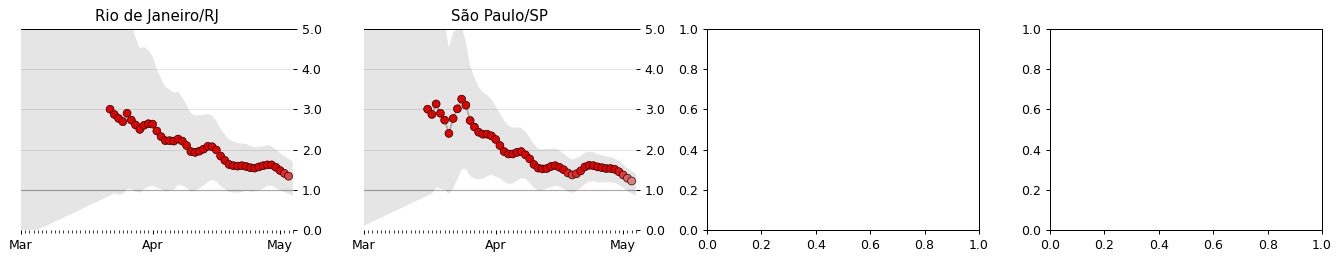

In [65]:
def plot_rt_states():

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('city')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()